In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

import math
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import time

In [2]:
# --- Core Computational Utilities ---

def compute_spectral_norm(matrix):
    """
    Computes the spectral norm of a matrix.
    """
    
    return torch.linalg.matrix_norm(matrix, ord=2)

In [3]:
def compute_l21_norm(matrix):
    """
    Computes the L(2,1) norm of a matrix: L2 norm of columns, then L1 of the result.
    """
    return torch.sum(torch.linalg.norm(matrix, ord=2, dim=0))

In [4]:
# --- Main Calculation Engine ---

def compute_spectral_complexity(model: nn.Module):
    """
    Computes the spectral complexity R_A for a given PyTorch model.
    """
    product_terms = list()
    summation_terms = list()
    
    device = next(model.parameters()).device

    max_layer_time = 0
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            print(f"Processing layer: {name} of type {type(module).__name__}")

            A_i = module.weight.data
            rho_i = 1.0  # Lipschitz constant for ReLU is 1
            
            start_time = time.perf_counter()

            if A_i.dim() == 4:
                A_i = A_i.view(A_i.size(0), -1)
            
            # 1. Compute spectral norm and product term
            s_i = compute_spectral_norm(A_i)
            
            
            
            # 2. Construct the reference matrix M_i
            M_i = torch.eye(A_i.size(0), A_i.size(1), device=device)
            
            # 3. Compute the deviation term for the summation
            # Formula requires ||A_i^T - M_i^T||_{2,1}
            deviation_matrix_T = A_i.T - M_i.T
            deviation_norm = compute_l21_norm(deviation_matrix_T)
            
            # Add a small epsilon to avoid division by zero if spectral norm is 0
            # sum_term = (deviation_norm**(2/3)) / ((s_i + 1e-12)**(2/3))
            sum_term = (deviation_norm / s_i)**(2/3)
            end_time = time.perf_counter()

            max_layer_time = max(max_layer_time, end_time - start_time)
            # sum_term = (deviation_norm / s_i)**(2/3)
            summation_terms.append(sum_term)
            product_terms.append(rho_i * s_i)

    # Calculate the final components
    # Product term: prod(rho_i * ||A_i||_sigma)
    total_product = torch.prod(torch.stack(product_terms))
    
    # Summation term: (sum(...))^(3/2)
    total_sum = torch.sum(torch.stack(summation_terms))
    final_sum_term = total_sum**(3/2)
    
    # Final Spectral Complexity R_A
    R_A = total_product * final_sum_term

    print(f"Maximum Computation Time for Layer: {max_layer_time:.4f}s")
    
    return R_A, total_product, final_sum_term

In [ ]:
def compute_dataset_l2_norm(loader):
    total_sq = 0.0
    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, (list, tuple)):
                inputs = batch[0]
            else:
                inputs = batch
            total_sq += torch.sum(inputs.float() ** 2).item()
    return total_sq ** 0.5


In [5]:
def compute_gamma_distribution(model_path):
    print("Loading pretrained ResNet-18 model...")
    model = models.resnet18(pretrained=False) # Set to True for transfer learning
    
    # Modify the first convolutional layer for single-channel input
    model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False) 
    # Note: Since we converted MNIST to 3 channels, no change needed here if you did that.
    # If keeping 1 channel, change 'in_channels' to 1. 
    
    # Modify the final fully connected layer for 10 output classes (digits 0-9)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10) # MNIST has 10 classes
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        
    # Set the model to evaluation mode
    model.eval()
        
    # Compute the spectral complexity
    print("\nComputing spectral complexity...")
    start_time = time.perf_counter()
    spectral_complexity, product_component, sum_component = compute_spectral_complexity(model)
    end_time = time.perf_counter()
    print(f"Total Computation Time: {end_time - start_time:.4f}s")
        
    print("\n--- Results ---")
    print(f"Product Component (Lipschitz-like term): {product_component.item():.4e}")
    print(f"Summation Component (Structural Deviation term): {sum_component.item():.4e}")
    print(f"Total Spectral Complexity (R_A): {spectral_complexity.item():.4e}")

    transform = transforms.Compose([
        transforms.Resize(224),  # Resize to ResNet's expected input size
        transforms.Grayscale(num_output_channels=3), # Convert to 3 channels
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # MNIST specific normalization
    ])
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(test_dataset, batch_size=1024, shuffle=False)
    dataset_l2_norm = compute_dataset_l2_norm(testloader)
    
    diffs = []
    all_l2_norms = 0
    
    with torch.no_grad():
        pbar = tqdm(testloader, desc=f"Eval: ")
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            top2 = torch.topk(outputs, k=2, dim=1).values
            diffs.extend((top2[:, 0] - top2[:, 1]).cpu().numpy())
    


    scaling = spectral_complexity.item() * dataset_l2_norm
    normal_diffs = np.array(diffs) / scaling

    return normal_diffs


In [6]:
underfit = compute_gamma_distribution("ckpt_resnet18_mnist/epoch_1.pth")
correct = compute_gamma_distribution("ckpt_resnet18_mnist/epoch_10.pth")
overfit = compute_gamma_distribution("ckpt_resnet18_mnist/epoch_50.pth")

Loading pretrained ResNet-18 model...


/home/samanway/.conda/envs/spectral_norm/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/samanway/.conda/envs/spectral_norm/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Computing spectral complexity...
Processing layer: conv1 of type Conv2d
Processing layer: layer1.0.conv1 of type Conv2d
Processing layer: layer1.0.conv2 of type Conv2d
Processing layer: layer1.1.conv1 of type Conv2d
Processing layer: layer1.1.conv2 of type Conv2d
Processing layer: layer2.0.conv1 of type Conv2d
Processing layer: layer2.0.conv2 of type Conv2d
Processing layer: layer2.0.downsample.0 of type Conv2d
Processing layer: layer2.1.conv1 of type Conv2d
Processing layer: layer2.1.conv2 of type Conv2d
Processing layer: layer3.0.conv1 of type Conv2d
Processing layer: layer3.0.conv2 of type Conv2d
Processing layer: layer3.0.downsample.0 of type Conv2d
Processing layer: layer3.1.conv1 of type Conv2d
Processing layer: layer3.1.conv2 of type Conv2d
Processing layer: layer4.0.conv1 of type Conv2d
Processing layer: layer4.0.conv2 of type Conv2d
Processing layer: layer4.0.downsample.0 of type Conv2d
Processing layer: layer4.1.conv1 of type Conv2d
Processing layer: layer4.1.conv2 of type C

Eval: 100%|██████████| 10/10 [01:13<00:00,  7.38s/it]


Loading pretrained ResNet-18 model...

Computing spectral complexity...
Processing layer: conv1 of type Conv2d
Processing layer: layer1.0.conv1 of type Conv2d
Processing layer: layer1.0.conv2 of type Conv2d
Processing layer: layer1.1.conv1 of type Conv2d
Processing layer: layer1.1.conv2 of type Conv2d
Processing layer: layer2.0.conv1 of type Conv2d
Processing layer: layer2.0.conv2 of type Conv2d
Processing layer: layer2.0.downsample.0 of type Conv2d
Processing layer: layer2.1.conv1 of type Conv2d
Processing layer: layer2.1.conv2 of type Conv2d
Processing layer: layer3.0.conv1 of type Conv2d
Processing layer: layer3.0.conv2 of type Conv2d
Processing layer: layer3.0.downsample.0 of type Conv2d
Processing layer: layer3.1.conv1 of type Conv2d
Processing layer: layer3.1.conv2 of type Conv2d
Processing layer: layer4.0.conv1 of type Conv2d
Processing layer: layer4.0.conv2 of type Conv2d
Processing layer: layer4.0.downsample.0 of type Conv2d
Processing layer: layer4.1.conv1 of type Conv2d
Proc

Eval: 100%|██████████| 10/10 [01:07<00:00,  6.77s/it]


Loading pretrained ResNet-18 model...

Computing spectral complexity...
Processing layer: conv1 of type Conv2d
Processing layer: layer1.0.conv1 of type Conv2d
Processing layer: layer1.0.conv2 of type Conv2d
Processing layer: layer1.1.conv1 of type Conv2d
Processing layer: layer1.1.conv2 of type Conv2d
Processing layer: layer2.0.conv1 of type Conv2d
Processing layer: layer2.0.conv2 of type Conv2d
Processing layer: layer2.0.downsample.0 of type Conv2d
Processing layer: layer2.1.conv1 of type Conv2d
Processing layer: layer2.1.conv2 of type Conv2d
Processing layer: layer3.0.conv1 of type Conv2d
Processing layer: layer3.0.conv2 of type Conv2d
Processing layer: layer3.0.downsample.0 of type Conv2d
Processing layer: layer3.1.conv1 of type Conv2d
Processing layer: layer3.1.conv2 of type Conv2d
Processing layer: layer4.0.conv1 of type Conv2d
Processing layer: layer4.0.conv2 of type Conv2d
Processing layer: layer4.0.downsample.0 of type Conv2d
Processing layer: layer4.1.conv1 of type Conv2d
Proc

Eval: 100%|██████████| 10/10 [01:06<00:00,  6.61s/it]


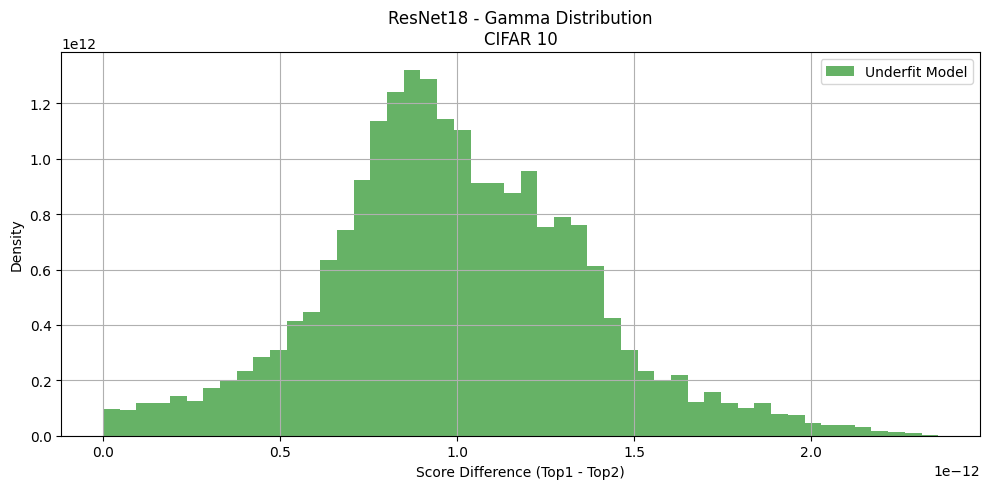

In [11]:
plt.figure(figsize=(10, 5))
plt.hist(underfit, bins=50, alpha=0.6, label="Underfit Model", color="green", density=True)
# plt.hist(correct, bins=50, alpha=0.6, label="Correct Model", color="blue", density=True)
# plt.hist(overfit, bins=50, alpha=0.6, label="Overfit Model", color="orange", density=True)
plt.xlabel("Score Difference (Top1 - Top2)")
plt.ylabel("Density")
plt.title(f"ResNet18 - Gamma Distribution\nCIFAR 10")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("gamma_hist_ResNet18_cifar10.png")
plt.show()

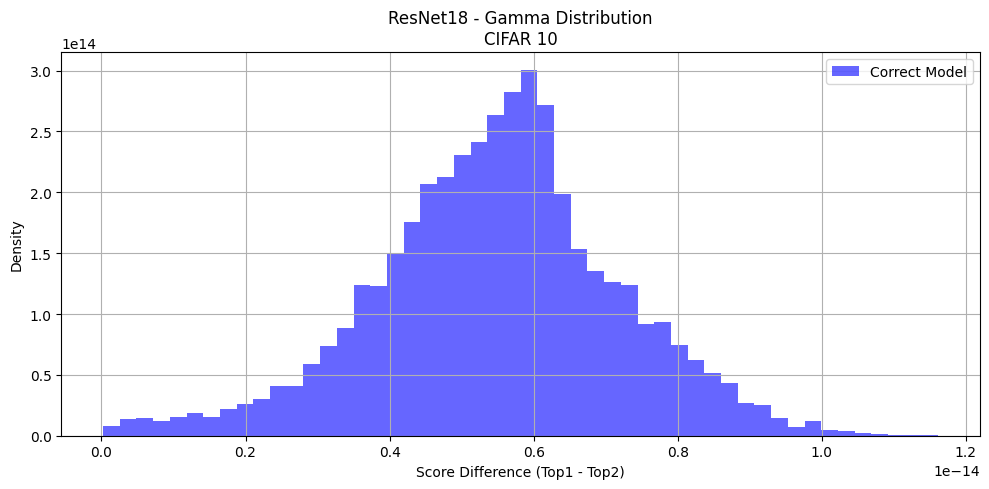

In [12]:
plt.figure(figsize=(10, 5))
# plt.hist(underfit, bins=50, alpha=0.6, label="Underfit Model", color="green", density=True)
plt.hist(correct, bins=50, alpha=0.6, label="Correct Model", color="blue", density=True)
# plt.hist(overfit, bins=50, alpha=0.6, label="Overfit Model", color="orange", density=True)
plt.xlabel("Score Difference (Top1 - Top2)")
plt.ylabel("Density")
plt.title(f"ResNet18 - Gamma Distribution\nCIFAR 10")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("gamma_hist_ResNet18_cifar10.png")
plt.show()

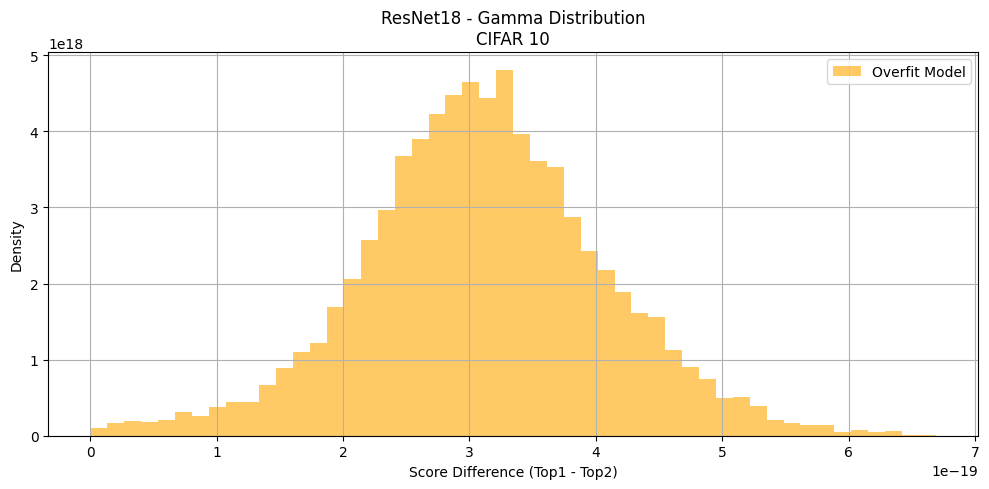

In [13]:
plt.figure(figsize=(10, 5))
# plt.hist(underfit, bins=50, alpha=0.6, label="Underfit Model", color="green", density=True)
# plt.hist(correct, bins=50, alpha=0.6, label="Correct Model", color="blue", density=True)
plt.hist(overfit, bins=50, alpha=0.6, label="Overfit Model", color="orange", density=True)
plt.xlabel("Score Difference (Top1 - Top2)")
plt.ylabel("Density")
plt.title(f"ResNet18 - Gamma Distribution\nCIFAR 10")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("gamma_hist_ResNet18_cifar10.png")
plt.show()

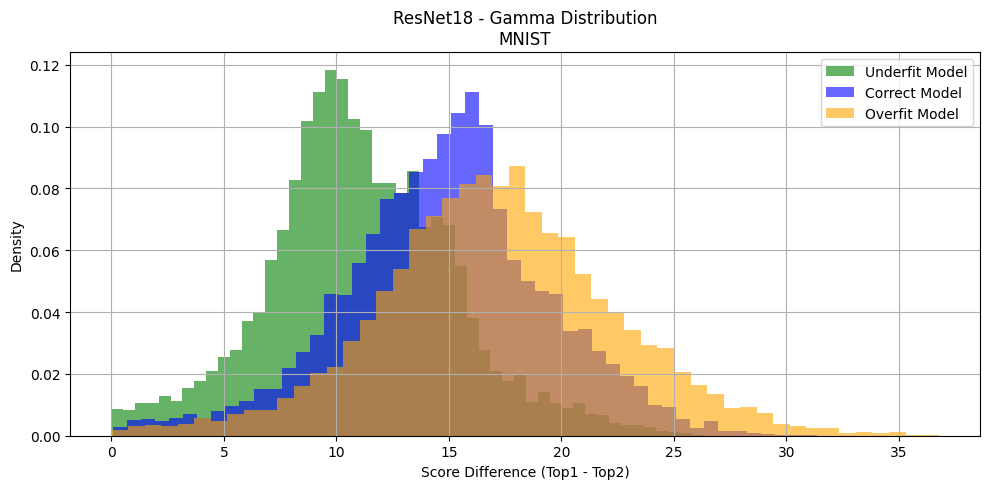

In [9]:
plt.figure(figsize=(10, 5))
plt.hist(underfit, bins=50, alpha=0.6, label="Underfit Model", color="green", density=True)
plt.hist(correct, bins=50, alpha=0.6, label="Correct Model", color="blue", density=True)
plt.hist(overfit, bins=50, alpha=0.6, label="Overfit Model", color="orange", density=True)
plt.xlabel("Score Difference (Top1 - Top2)")
plt.ylabel("Density")
plt.title(f"ResNet18 - Gamma Distribution\nMNIST")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gamma_hist_ResNet18_mnist.png")
plt.show()

In [2]:
transform = transforms.Compose([
    transforms.Resize(224),  # Resize to ResNet's expected input size
    transforms.Grayscale(num_output_channels=3), # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # MNIST specific normalization
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [3]:
model = models.resnet18(pretrained=True)

# Modify the first convolutional layer for single-channel input
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False) 
# Note: Since we converted MNIST to 3 channels, no change needed here if you did that.
# If keeping 1 channel, change 'in_channels' to 1. 

# Modify the final fully connected layer for 10 output classes (digits 0-9)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10) # MNIST has 10 classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/home/samanway/.conda/envs/torch_gpu/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/samanway/.conda/envs/torch_gpu/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200) # Optional: Learning rate scheduler

epochs = 50 # Adjust as needed

train_acc = list()
test_acc = list()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    correct = 0
    total = 0
    pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}, Train: ")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    train_acc_ = 100 * correct / total
    scheduler.step() # If using a scheduler

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(testloader, desc=f"Eval: ")
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    test_acc_ = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}, train acc: {train_acc_:.2f}%, test acc: {test_acc_:.2f}%")
    train_acc.append(train_acc_)
    test_acc.append(test_acc_)
    torch.save(model.state_dict(), f"ckpt_resnet18_mnist/epoch_{epoch+1}.pth")

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_acc, label="Train Accuracy")
plt.plot(range(1, epochs + 1), test_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Resnet18 MNIST Accuracy Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"resnet18_mnist_accuracy_curve.png")
plt.show()

Eval: 100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


Epoch 1, Loss: 0.0341, train acc: 98.97%, test acc: 98.95%


Eval: 100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


Epoch 2, Loss: 0.0200, train acc: 99.40%, test acc: 99.31%


Eval: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


Epoch 3, Loss: 0.0127, train acc: 99.60%, test acc: 99.28%


Eval: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


Epoch 4, Loss: 0.0095, train acc: 99.73%, test acc: 99.49%


Eval: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


Epoch 5, Loss: 0.0103, train acc: 99.67%, test acc: 99.42%


Eval: 100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


Epoch 6, Loss: 0.0068, train acc: 99.78%, test acc: 99.31%


Eval: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


Epoch 7, Loss: 0.0049, train acc: 99.85%, test acc: 99.61%


Eval: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Epoch 8, Loss: 0.0030, train acc: 99.91%, test acc: 99.43%


Eval: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Epoch 9, Loss: 0.0056, train acc: 99.80%, test acc: 99.23%


Eval: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


Epoch 10, Loss: 0.0046, train acc: 99.83%, test acc: 99.36%


Eval: 100%|██████████| 10/10 [00:17<00:00,  1.70s/it]


Epoch 11, Loss: 0.0071, train acc: 99.76%, test acc: 99.30%


Eval: 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


Epoch 12, Loss: 0.0061, train acc: 99.80%, test acc: 99.29%


Eval: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


Epoch 13, Loss: 0.0018, train acc: 99.95%, test acc: 99.59%


Eval: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Epoch 14, Loss: 0.0008, train acc: 99.98%, test acc: 99.48%


Eval: 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


Epoch 15, Loss: 0.0079, train acc: 99.76%, test acc: 99.50%


Eval: 100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


Epoch 16, Loss: 0.0074, train acc: 99.75%, test acc: 99.57%


Eval: 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Epoch 17, Loss: 0.0011, train acc: 99.97%, test acc: 99.51%


Eval: 100%|██████████| 10/10 [00:30<00:00,  3.07s/it]


Epoch 18, Loss: 0.0006, train acc: 99.98%, test acc: 99.52%


Eval: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


Epoch 19, Loss: 0.0006, train acc: 99.99%, test acc: 99.53%


Eval: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Epoch 20, Loss: 0.0003, train acc: 99.99%, test acc: 99.55%


Eval: 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


Epoch 21, Loss: 0.0000, train acc: 100.00%, test acc: 99.59%


Epoch 22/50, Train:  52%|█████▏    | 61/118 [01:36<01:15,  1.33s/it]

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_acc, label="Train Accuracy")
plt.plot(range(1, epochs + 1), test_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Resnet18 MNIST Accuracy Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"resnet18_mnist_accuracy_curve.png")
plt.show()